In [1]:
%%HTML
<style>.container { width:100% !important; }</style>

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
#import netgraph
# import mpld3
# mpld3.enable_notebook()

hosts = ["fiona.its.hawaii.edu", "sage2rtt.evl.uic.edu", "fiona.nwsc.ucar.edu", "rci-dmz01.msu.montana.edu", \
         "fiona.cac.washington.edu", "airplane03-dmz.chpc.utah.edu", "dtn0.noc.ucdavis.edu", \
        "ucsf-scidmz-dtn1.ucsf.edu", "netw-fiona.stanford.edu", "ucm-fiona00.ucmerced.edu", "fiona-dtn-1.ucsc.edu",
        "prp-dtn.noc.ucsb.edu", "dtn.ultralight.org", "fiona.tools.ucla.net", "fiona-dtn.usc.edu", \
         "dtn0.lsanca.pacificwave.net", "dtn-main.ucr.edu", "fiona.oit.uci.edu", \
         "ps-40g-gridftp.calit2.optiputer.net", "fiona.sdsu.edu"
        ]

In [6]:
import re
import itertools

def gen_key(host_pair):
    return "%s %s"%(host_pair[0], host_pair[1])

trace_results = {}

#for pair in [pair for pair in itertools.permutations(hosts, 2) if pair[0] < pair[1]]:
for pair in [pair for pair in itertools.permutations(hosts[4:], 2)]:
    tracert_output = !bwtraceroute -s {pair[0]} -c {pair[1]} -T tracepath
    key = gen_key(pair)
    if(tracert_output[0].lstrip().startswith("bwtraceroute: Unable to connect")):
        trace_results[key] = [{
            "error": tracert_output[0]
        }]
    else:
        for line in tracert_output:
            line_sp = [x for x in line.lstrip().split(" ") if x] # removing empty lines
            if(line_sp and re.match("\d+\:", line_sp[0])): # only lines with numbers - the actial results

                if(key not in trace_results):
                    trace_results[key] = []
                
                try:
                    trace_results[key].append(
                        {
                            "target": line_sp[1],
                            "result": line_sp[2]
                        }
                    )
                except Exception, e:
                    print e
                    print key, "", line_sp

list index out of range
ucm-fiona00.ucmerced.edu airplane03-dmz.chpc.utah.edu  ['8:']
list index out of range
ucm-fiona00.ucmerced.edu fiona.tools.ucla.net  ['6:']
list index out of range
fiona.tools.ucla.net ucsf-scidmz-dtn1.ucsf.edu  ['6:']
list index out of range
fiona-dtn.usc.edu airplane03-dmz.chpc.utah.edu  ['4:']
list index out of range
fiona-dtn.usc.edu fiona.tools.ucla.net  ['5:']
list index out of range
fiona-dtn.usc.edu ps-40g-gridftp.calit2.optiputer.net  ['5:']
list index out of range
dtn0.lsanca.pacificwave.net airplane03-dmz.chpc.utah.edu  ['5:']
list index out of range
dtn0.lsanca.pacificwave.net ucsf-scidmz-dtn1.ucsf.edu  ['3:']
list index out of range
dtn0.lsanca.pacificwave.net fiona.tools.ucla.net  ['3:']
list index out of range
dtn-main.ucr.edu airplane03-dmz.chpc.utah.edu  ['8:']
list index out of range
dtn-main.ucr.edu ucsf-scidmz-dtn1.ucsf.edu  ['6:']
list index out of range
dtn-main.ucr.edu fiona.tools.ucla.net  ['6:']
list index out of range
ps-40g-gridftp.cal

In [7]:
from bokeh.io import output_notebook, show
output_notebook()
import pandas as pd




Loading BokehJS ...

In [8]:
import networkx as nx
import json
g = nx.Graph()
g.add_nodes_from(hosts)

for key, value in trace_results.iteritems():
    prev_item = None
    for item in value:
        if "error" not in item:
            g.add_node(item["target"])
            if prev_item is not None:
                if prev_item != item["target"]:
                    g.add_edge(prev_item, item["target"], weight=1)
#                     print "Added %s to %s"%(prev_item, item["target"])
            else:
                g.add_edge(key.split(" ")[0], item["target"], weight=1)# first edge from source
#                 print "! Added %s to %s"%(key.split(" ")[0], item["target"])
            prev_item = item["target"]
    if("target" in value[-1] and value[-1]["target"] != key.split(" ")[1]):
        g.add_edge(value[-1]["target"], key.split(" ")[1], weight=1) # last edge to destination
#         print "!! Added %s to %s"%(value[-1]["target"], key.split(" ")[1])

import numpy as np
def get_coordinates_in_circle(n):
    thetas = [2*np.pi*(float(i)/n) for i in range(n)]
    returnlist = [(np.cos(theta)*500+400,np.sin(theta)*200+400) for theta in thetas]
    return returnlist

circular_positions = get_coordinates_in_circle(len(hosts))

for index, node in enumerate(hosts):
    g.node[node]["fx"] = circular_positions[index][0]
    g.node[node]["fy"] = circular_positions[index][1]

from networkx.readwrite.json_graph import node_link_data
from IPython.display import Javascript
# print json.dumps(node_link_data(g));
Javascript("""
           window.vizObj={};
           """.format(json.dumps(node_link_data(g))))
# print json.dumps(node_link_data(g))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


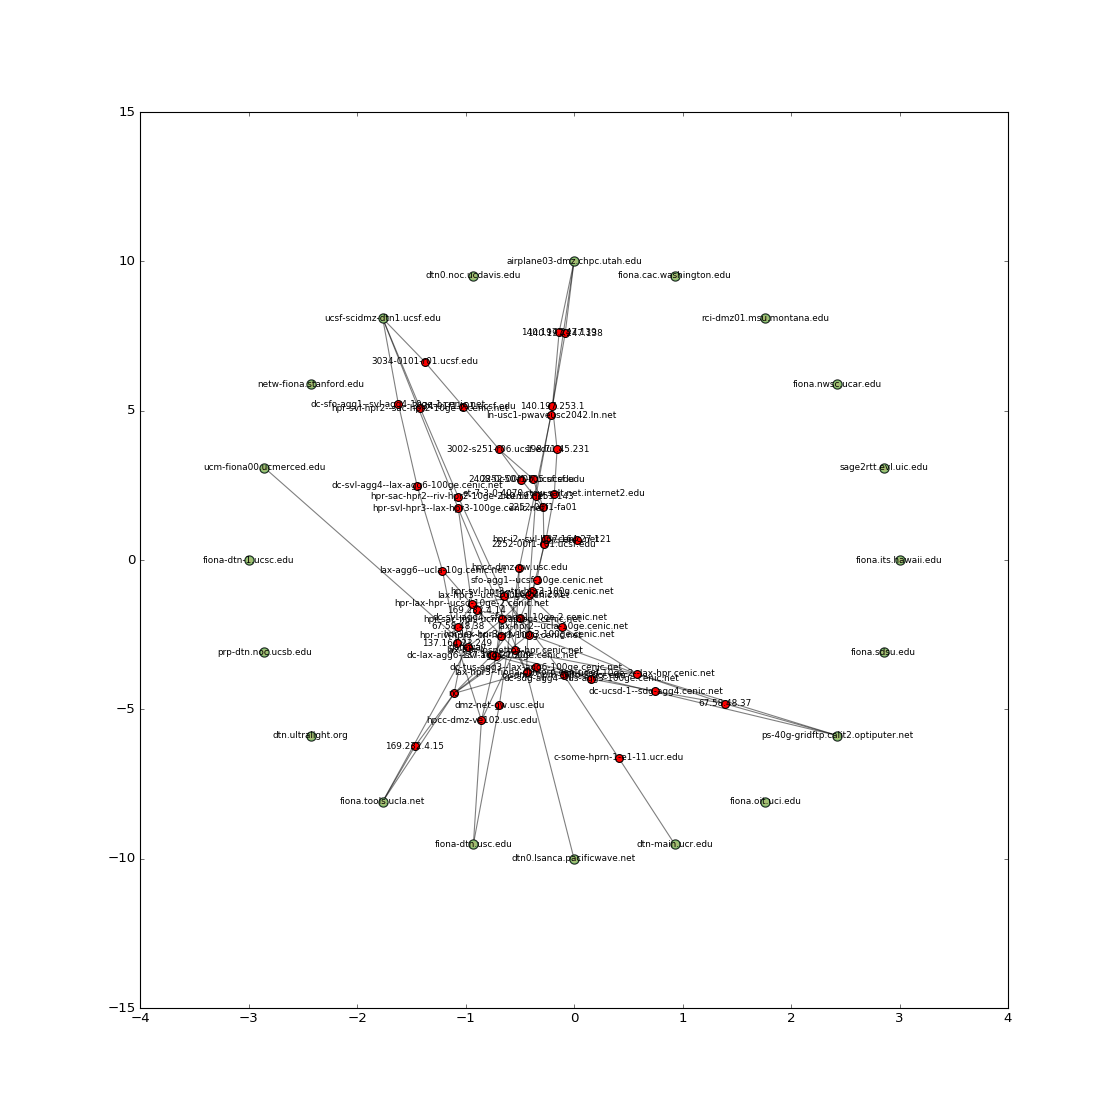

In [9]:
import numpy as np
def get_coordinates_in_circle(n):
    thetas = [2*np.pi*(float(i)/n) for i in range(n)]
    returnlist = [(np.cos(theta)*3,np.sin(theta)*10) for theta in thetas]
    return returnlist

circular_positions = get_coordinates_in_circle(len(hosts))

fixed_positions = {node:circular_positions[index] for index, node in enumerate(hosts)}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(g,pos=fixed_positions, fixed = fixed_nodes, k=0.2)
#pos = nx.shell_layout(g,pos=fixed_positions, fixed = fixed_nodes)

plt.figure(3,figsize=(14,14)) 

nx.draw_networkx_nodes(g,pos,
                       node_color='r',
                       node_size=50)
nx.draw_networkx_nodes(g,pos,
                       nodelist=hosts,
                       node_color='lightgreen',
                       node_size=70,
                   alpha=0.8)

nx.draw_networkx_edges(g,pos,width=1,alpha=0.5)
nx.draw_networkx_labels(g,pos,font_size=8)

plt.show()

In [10]:
from bokeh.models import ColumnDataSource

nodes, nodes_coordinates = zip(*sorted(pos.items()))
nodes_xs, nodes_ys = list(zip(*nodes_coordinates))
nodes_source = ColumnDataSource(dict(x=nodes_xs, y=nodes_ys,
                                     name=nodes))
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import HoverTool

hover = HoverTool(tooltips=[('name', '@name'), ('id', '$index')])
plot = figure(plot_width=1800, plot_height=1400,
              tools=['tap', hover, 'box_zoom', 'reset'])
r_circles = plot.circle('x', 'y', source=nodes_source, size=10,
                        color='blue', level = 'overlay')
# output_notebook(); show(plot)

def get_edges_specs(_network, _layout):
    d = {'xs':[], 'ys':[], 'alphas':[]}
    weights = [b['weight'] for u, v, b in _network.edges(data=True)]
    max_weight = max(weights)
    calc_alpha = lambda h: 0.1 + 0.6 * (h / max_weight)
    for u, v, data in _network.edges(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
        d['alphas'].append(calc_alpha(data['weight']))
    return d

lines_source = ColumnDataSource(get_edges_specs(g, pos))

r_lines = plot.multi_line('xs', 'ys', line_width=1.5,
                          alpha='alphas', color='navy',
                          source=lines_source)
show(plot)

In [2]:
%%javascript

element.append("<svg width='1200' height='900'></svg>");
var graph = window.vizObj;

require(["//cdnjs.cloudflare.com/ajax/libs/d3/4.3.0/d3.min.js"], function(d3) {
var svg = d3.select("svg"),
    width = +svg.attr("width"),
    height = +svg.attr("height");

var color = d3.scaleOrdinal(d3.schemeCategory20);

var simulation = d3.forceSimulation()
    .force("link", d3.forceLink().id(function(d,i) { return i; }))
    .force("charge", d3.forceManyBody())
    .force("center", d3.forceCenter(width / 2, height / 2));

  simulation
    .nodes(graph.nodes);
  
  simulation
    .force("link")
    .links(graph.links);

  var link = svg.selectAll(".link")
      .data(graph.links)
    .enter().append("line")
      .attr("stroke-width", "2")
      .attr("stroke", "black");

  var node = svg.selectAll(".node")
      .data(graph.nodes)
    .enter().append("g")
      .attr("class", "node");

  node.append("circle")
      .attr("r", 5)
      .attr("fill", function(d) { return color(d.group); })
      .call(d3.drag()
          .on("start", dragstarted)
          .on("drag", dragged)
          .on("end", dragended));

  node.append("text")
      .attr("text-anchor", "middle")
//       .attr("dx", "-20px")
      .attr("dy", "-.5em")
      .text(function(d) { return d.id });

  simulation.on("tick", function() {
    link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("transform", function(d) { return "translate(" + d.x + "," + d.y + ")"; });
});


function dragstarted(d) {
  if (!d3.event.active) simulation.alphaTarget(0.3).restart();
  d.fx = d.x;
  d.fy = d.y;
}

function dragged(d) {
  d.fx = d3.event.x;
  d.fy = d3.event.y;
}

function dragended(d) {
  if (!d3.event.active) simulation.alphaTarget(0);
  d.fx = null;
  d.fy = null;
}

});




<IPython.core.display.Javascript object>